## 1. Tải dữ liệu

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/horse-or-human.zip \
    -O ./horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip \
    -O ./validation-horse-or-human.zip

--2023-10-11 07:48:43--  https://storage.googleapis.com/learning-datasets/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘./horse-or-human.zip’

./horse-or-human.zi 100%[===================>] 142.65M  18.1MB/s    in 8.9s    

2023-10-11 07:48:52 (16.0 MB/s) - ‘./horse-or-human.zip’ saved [149574867/149574867]

--2023-10-11 07:48:52--  https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving 

In [ ]:
train_folder = './horse-or-human'
valid_folder = './validation-horse-or-human'

!unzip -q horse-or-human.zip -d $train_folder

!unzip -q validation-horse-or-human.zip -d $valid_folder

train_horse_dir = './horse-or-human/horses'
train_human_dir = './horse-or-human/humans'
valid_horse_dir = 'validation-horse-or-human/horses'
valid_human_dir = 'validation-horse-or-human/humans'

## 2. Load dữ liệu

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 2.1. Chuẩn hóa dữ liệu

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255)
valid_generator = ImageDataGenerator(rescale=1/255)

### 2.2. Load nhanh dữ liệu dưới dạng generator

In [ ]:
!nvidia-smi

Fri Aug 26 12:39:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
generated_train_data = train_generator.flow_from_directory(
    train_folder,
    target_size= (150, 150),
    batch_size=64,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [ ]:
generated_train_data.class_indices

{'horses': 0, 'humans': 1}

In [ ]:
generated_valid_data = valid_generator.flow_from_directory(
    valid_folder,
    target_size= (150, 150),
    batch_size=64,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


## 3. Xây dựng mô hình

### 3.1. Xây dựng các lớp Convolution

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
model = Sequential(
  [Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  MaxPooling2D(2, 2),
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),]
  )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

### 3.2. Thêm lớp phân loại

In [ ]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

## 4.Tiến hành training

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['acc'])

In [ ]:
history = model.fit(
    generated_train_data,
    epochs = 15,
    verbose=1,
    validation_data = generated_valid_data,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/15
17/17 [==============================] - 20s 380ms/step - loss: 0.6248 - acc: 0.7011 - val_loss: 0.5238 - val_acc: 0.7852
Epoch 2/15
17/17 [==============================] - 6s 378ms/step - loss: 0.3954 - acc: 0.8559 - val_loss: 0.5696 - val_acc: 0.7344
Epoch 3/15
17/17 [==============================] - 6s 379ms/step - loss: 0.2134 - acc: 0.9620 - val_loss: 0.2909 - val_acc: 0.8906
Epoch 4/15
17/17 [==============================] - 6s 378ms/step - loss: 0.1645 - acc: 0.9562 - val_loss: 1.0145 - val_acc: 0.6992
Epoch 5/15
17/17 [==============================] - 6s 378ms/step - loss: 0.1543 - acc: 0.9503 - val_loss: 1.0488 - val_acc: 0.7344
Epoch 6/15
17/17 [==============================] - 6s 376ms/step - loss: 0.0899 - acc: 0.9815 - val_loss: 1.2434 - val_acc: 0.7227
Epoch 7/15
17/17 [==============================] - 6s 379ms/step - loss: 0.0766 - acc: 0.9805 - val_loss: 1.0605 - val_acc: 0.8047
Epoch 8/15
17/17 [==============================] - 6s 378ms/step - loss: 0

## 5. Tiến hành dự đoán

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # prediction Process
  path = './' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img) / 255

  # (1, 150, 150, 3)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  print(images.shape)

  classes = model.predict(images, batch_size=10)

  if classes[0] > 0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


TypeError: ignored

## 6. Hiển thị feature map

Saving ngoc.jpg to ngoc.jpg
(1, 150, 150, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


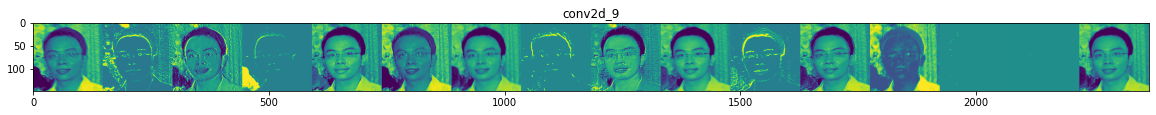

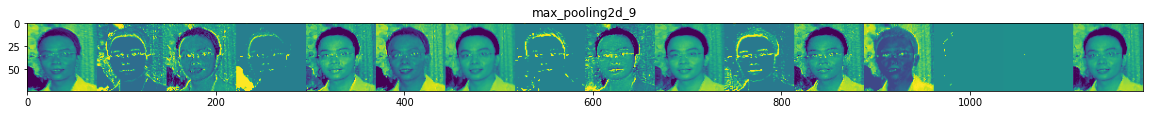

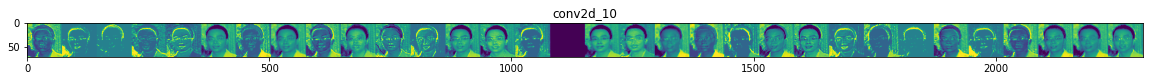

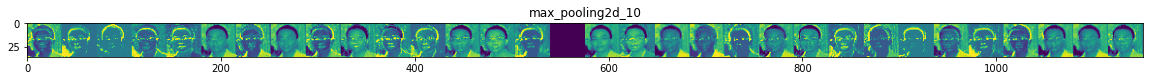

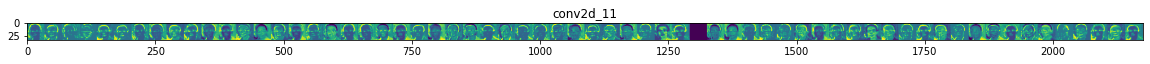

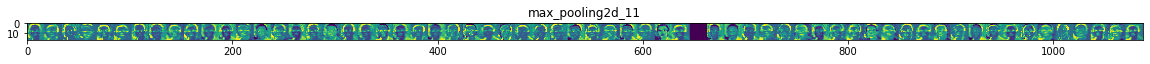

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

ouput_layers = [
  layer.output for layer in model.layers

]

uploaded = files.upload()

for fn in uploaded.keys():

  # prediction Process

  path = './' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img) / 255

  x = x.reshape((1,) + x.shape)


  print(x.shape)

  visualization_model = tf.keras.models.Model(inputs = model.input, outputs = ouput_layers)

  successive_feature_maps = visualization_model.predict(x)


  layer_names = [layer.name for layer in model.layers]

  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
      n_features = feature_map.shape[-1]  # number of features in feature map
      # The feature map has shape (1, size, size, n_features)
      size = feature_map.shape[1]
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
      for i in range(n_features):
        # Postprocess the feature to make it visually palatable
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
      # Display the grid
      scale = 20. / n_features
      plt.figure(figsize=(scale * n_features, scale))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')
